# 1.Setup

In [105]:
# Library untuk manipulasi data dan numerik
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library Scikit-Learn untuk pemodelan machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library TensorFlow/Keras untuk Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Perintah khusus untuk Jupyter Notebook/IPython agar plot tampil inline
%matplotlib inline

# 2. Load Dataset & Word Embeddings (Glove/Word2Vec)

## 2.1. Load Data

In [ ]:
file_path = "tweet_bersih.csv"
df = pd.read_csv(file_path)

## 2.2. Load Pre-trained Word Embeddings (Word2Vec/Glove-like format)

In [107]:
glove_file = r"E:\My Drive\Indonesia AI\Fundamental NLP\Project 1\Data_raw\Word2Vec_400dim.txt"
embedding_dim = 400
embeddings_index = {}

print("Loading word vectors...")
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        # Logika dasar: Memastikan baris memiliki format yang benar
        try:
            # Coba konversi nilai pertama setelah kata menjadi float
            float(values[1])
        except (ValueError, IndexError):
            # Lompati baris jika tidak dapat dikonversi atau tidak ada nilai
            continue

        word = values[0]
        # Konversi sisa nilai ke array numpy float32
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f'Loaded {len(embeddings_index)} word vectors.')

Loading word vectors...
Loaded 129391 word vectors.


## 2.3. Data Preparation

In [108]:
X = df['tweet_bersih'].astype(str)
y = df['sentimen']

# Encode labels (Mapping string label ke integer)
encoder = {'negatif': 0, 'netral': 1, 'positif': 2}
y_encode = y.map(encoder)

# One-Hot Encoding untuk output (sesuai kebutuhan Keras/TensorFlow)
y_encode = to_categorical(y_encode, num_classes=3)

# 3. Text Preprocessing (Tokenization & Padding)

## 3.1. Tokenisasi

In [109]:
MAX_LEN = 35

# Inisiasi Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(X)

# Convert texts to sequences
X_seq = tokenizer.texts_to_sequences(X)

# Padding (membuat panjang sequence seragam)
# panjang_token = [len(s) for s in X_seq] # Code ini di-komen, dipindahkan ke sini agar rapi
# print(np.percentile(panjang_token, 90)) # Code ini di-komen, dipindahkan ke sini agar rapi
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

## 3.2. Embedding Matrix Creation

In [110]:
vocab_size = len(tokenizer.word_index) + 1  # +1 for reserved 0 index (padding)
# embedding_dim sudah didefinisikan di awal (400)

embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Mengisi embedding matrix dengan vector dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector


## 3.3. Data Splitting

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_encode,
    test_size=0.2,
    random_state=16
)

# 4. Model Building & Training (Bi-LSTM)

## 4.1. Model Definition

In [112]:
L2_REG = 0.005

model_lstm = Sequential([
    # Layer 1: Embedding
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True  # Agar bobot embedding dapat di-update selama training
    ),
    # Layer 2: Bi-directional LSTM
    Dropout(0.5),
    Bidirectional(
        LSTM(
            24,
            dropout=0.2,
            recurrent_dropout=0.2,
            kernel_regularizer=l2(L2_REG)
        )
    ),
    # Layer 3: Dropout
    Dropout(0.5),
    # Layer 4: Output Dense Layer (3 kelas, Softmax)
    Dense(
        3,
        activation='softmax',
        kernel_regularizer=l2(L2_REG)
    )
])


## 4.2. Compile Model

In [113]:
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0002),
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │     2,245,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,245,200 (8.56 MB)

 Trainable params: 2,245,200 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

## 4.3. Training Model

In [114]:
print("\nTraining model...")
# Callback untuk Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

history = model_lstm.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stopping] # Menggunakan nama variabel callback
)


Training model...
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.3558 - loss: 2.6197 - val_accuracy: 0.3761 - val_loss: 2.5017
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3971 - loss: 2.4221 - val_accuracy: 0.4083 - val_loss: 2.3394
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3849 - loss: 2.2854 - val_accuracy: 0.4174 - val_loss: 2.1997
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.3947 - loss: 2.1673 - val_accuracy: 0.4266 - val_loss: 2.0808
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4117 - loss: 2.0336 - val_accuracy: 0.4541 - val_loss: 1.9769
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.4238 - loss: 1.9451 - val_accuracy: 0.4633 - val_loss: 1.8823
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.4465 - loss: 1.8500 - val_accuracy: 0.5138 - val_loss: 1.7902
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4911 - loss: 1.767

# 5. Model Evaluation

## 5.1. Prediction

In [115]:
# Prediksi untuk data test dan train
y_pred_prob_test = model_lstm.predict(X_test)
y_pred_prob_train = model_lstm.predict(X_train)

# Konversi probabilitas ke label kelas (0, 1, 2)
y_pred_test = np.argmax(y_pred_prob_test, axis=1)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

# Konversi label One-Hot True ke label kelas (0, 1, 2)
y_true_test = np.argmax(y_test, axis=1)
y_true_train = np.argmax(y_train, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


## 5.2. Metrics Calculation

In [116]:
target_names = ['negatif', 'netral', 'positif']

accuracy_test = accuracy_score(y_true_test, y_pred_test)
accuracy_train = accuracy_score(y_true_train, y_pred_train)

print(f'\nAkurasi Training: {accuracy_train:.4f}')
print(f'Akurasi Test: {accuracy_test:.4f}')
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=target_names))


Akurasi Training: 0.8230
Akurasi Test: 0.6171

Classification Report:
              precision    recall  f1-score   support

     negatif       0.62      0.53      0.57       116
      netral       0.64      0.73      0.68       124
     positif       0.59      0.58      0.58       123

    accuracy                           0.62       363
   macro avg       0.62      0.62      0.61       363
weighted avg       0.62      0.62      0.61       363



## 5.3. Confusion Matrix Visualization

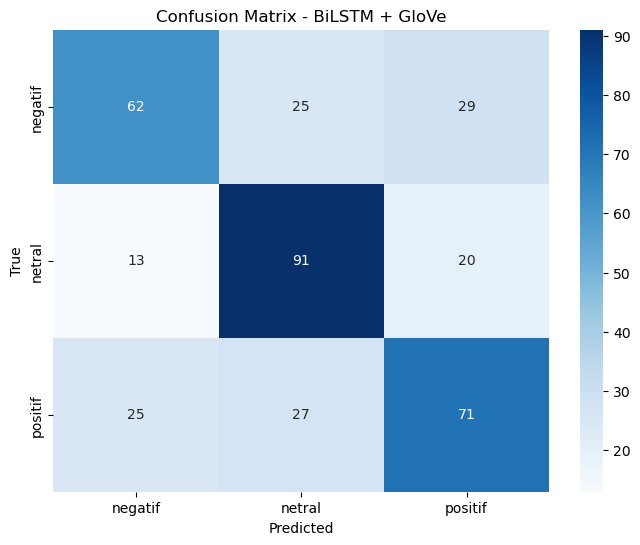

In [117]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, # Menampilkan nilai di setiap sel
    fmt='d',    # Format integer
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BiLSTM + GloVe')
plt.show()

## 5.4. Visualisasi Kurva Akurasi dan Loss

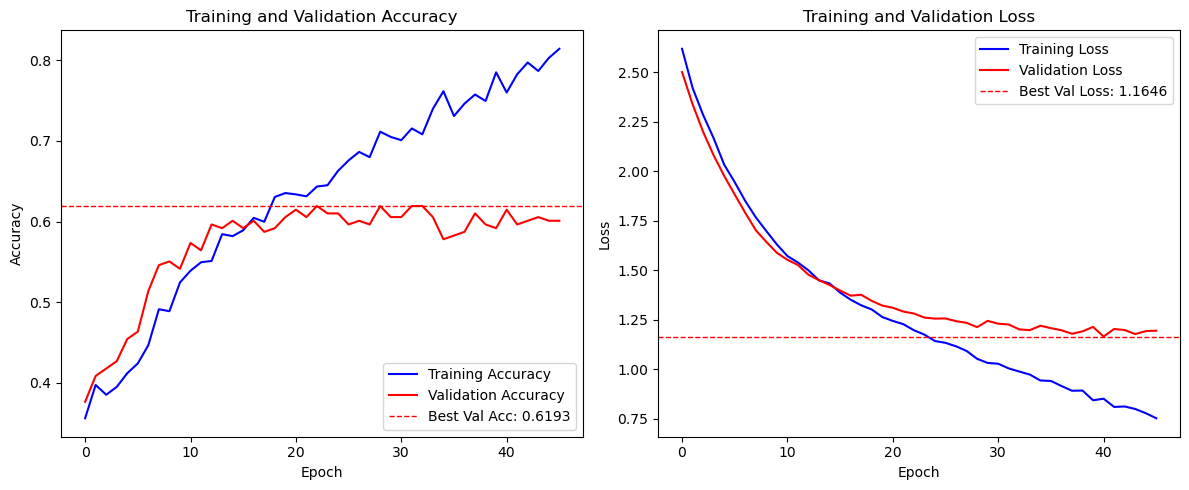

In [118]:
def plot_history(history):
    """
    Membuat dua plot: 
    1. Kurva Akurasi (Training vs Validation)
    2. Kurva Loss (Training vs Validation)
    """
    
    # Ambil data dari objek history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    # Plot 1: Akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1) # Membuat grid 1 baris, 2 kolom, dan plot di posisi 1
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.axhline(y=max(val_acc), color='red', linestyle='--', linewidth=1, 
                label=f'Best Val Acc: {max(val_acc):.4f}')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot 2: Loss
    plt.subplot(1, 2, 2) # Membuat grid 1 baris, 2 kolom, dan plot di posisi 2
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.axhline(y=min(val_loss), color='red', linestyle='--', linewidth=1, 
                label=f'Best Val Loss: {min(val_loss):.4f}')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout() # Penyesuaian agar plot tidak bertumpuk
    plt.show()

# Panggil fungsi plot setelah training selesai
plot_history(history)